In [1]:
from utils import load_dtrajs_from_npz
raw_dtrajs_abl = load_dtrajs_from_npz('dtrajs/abl_11400_2000_dtrajs.npz')

# trim dtrajs when building MSM
def trim_dtrajs(dtrajs,length_to_discard=10,min_length=100):
    trimmed = [traj[length_to_discard:] for traj in dtrajs if len(traj)>length_to_discard]
    return trimmed

dtrajs_abl = trim_dtrajs(raw_dtrajs_abl)

# build MSM
import msmbuilder.msm
lag_frames = 40
ergodic_cutoff_in_frames=20
ergodic_cutoff = 1.0*ergodic_cutoff_in_frames/lag_frames
mb_msm_abl = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_abl.fit(dtrajs_abl)
print(mb_msm_abl.summarize())
M = mb_msm_abl

MSM contains 1430 strongly connected components above weight=0.50. Component 178 selected, with population 72.095405%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 338
Number of nonzero entries in counts matrix : 6216 (5.44098595988%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.1
    Mean   : 2.2
    3rd Qu.: 0.5
    Max.   : 1487.5

Total transition counts :
    13631.35 counts
Total transition counts / lag_time:
    340.78375 units
Timescales:
    [2169.54, 1907.65, 1858.34, 1800.73, 1659.07, 1590.01, 1542.29, 1477.60, 1345.10, 1332.19, 1191.67, 1156.80, 1068.17, 982.33, 933.27, 815.23, 752.10, 700.40, 695.71, 647.44, 637.63, 629.52, 600.83, 540.80, 534.18, 532.25, 529.38, 506.88, 501.71, 420.72, 402.92, 399.72, 398.36, 386.80, 382.91, 381.67, 379.46, 372.06, 366.12, 364.78, 362.00, 356.31, 339.54, 328.00, 324.58, 324.00, 315.33, 300.18, 295.68, 285

In [62]:
import numpy as np

def flat_probs_from_msm(flat_labels,M,n_micro=2000):

    # probability per snapshot = microstate_probability/nsamples_in_microstate
    label_probabilities = np.zeros(n_micro)
    for label in M.mapping_:
        nsamples_per_label = np.sum(flat_labels==label)
        pi_label = M.populations_[M.mapping_[label]]
        label_probabilities[label] = pi_label / nsamples_per_label
    flat_probs = np.array([label_probabilities[i] for i in flat_labels])
    
    return flat_probs

# flatten labels
flat_labels = np.hstack(raw_dtrajs_abl)
flat_probs = flat_probs_from_msm(flat_labels,M,n_micro=len(set(flat_labels)))

# define reducing function to color each bin: 
# free energy of a bin = -\ln (\sum_snapshots probability(snapshot))
reducing_function = lambda x:-np.log(np.sum(x))

/Users/joshuafass/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log


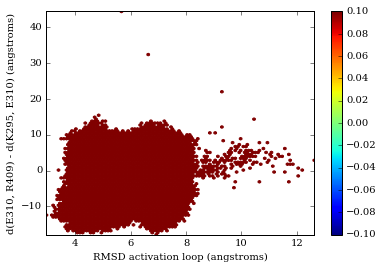

In [39]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
%matplotlib inline

# # placeholders before data shows up
# X1 = np.random.rand(len(np.hstack(raw_dtrajs_abl)))
# X2 = np.random.rand(len(np.hstack(raw_dtrajs_abl)))

X1 = np.load('rmsd_ABL.npy')            # of shape (N)
X2 = np.load('difference_ABL.npy')[:,0] # since it's of shape (N,1)


thin=1
plt.hexbin(X1[::thin],X2[::thin],C=flat_probs[::thin],
           reduce_C_function=reducing_function,
           #cmap='Blues'
          )

plt.xlabel('RMSD activation loop (angstroms)')
plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
plt.colorbar()

In [40]:
# something doesn't look right
# on the other hand, the lovely developers of PyEMMA have already done this!

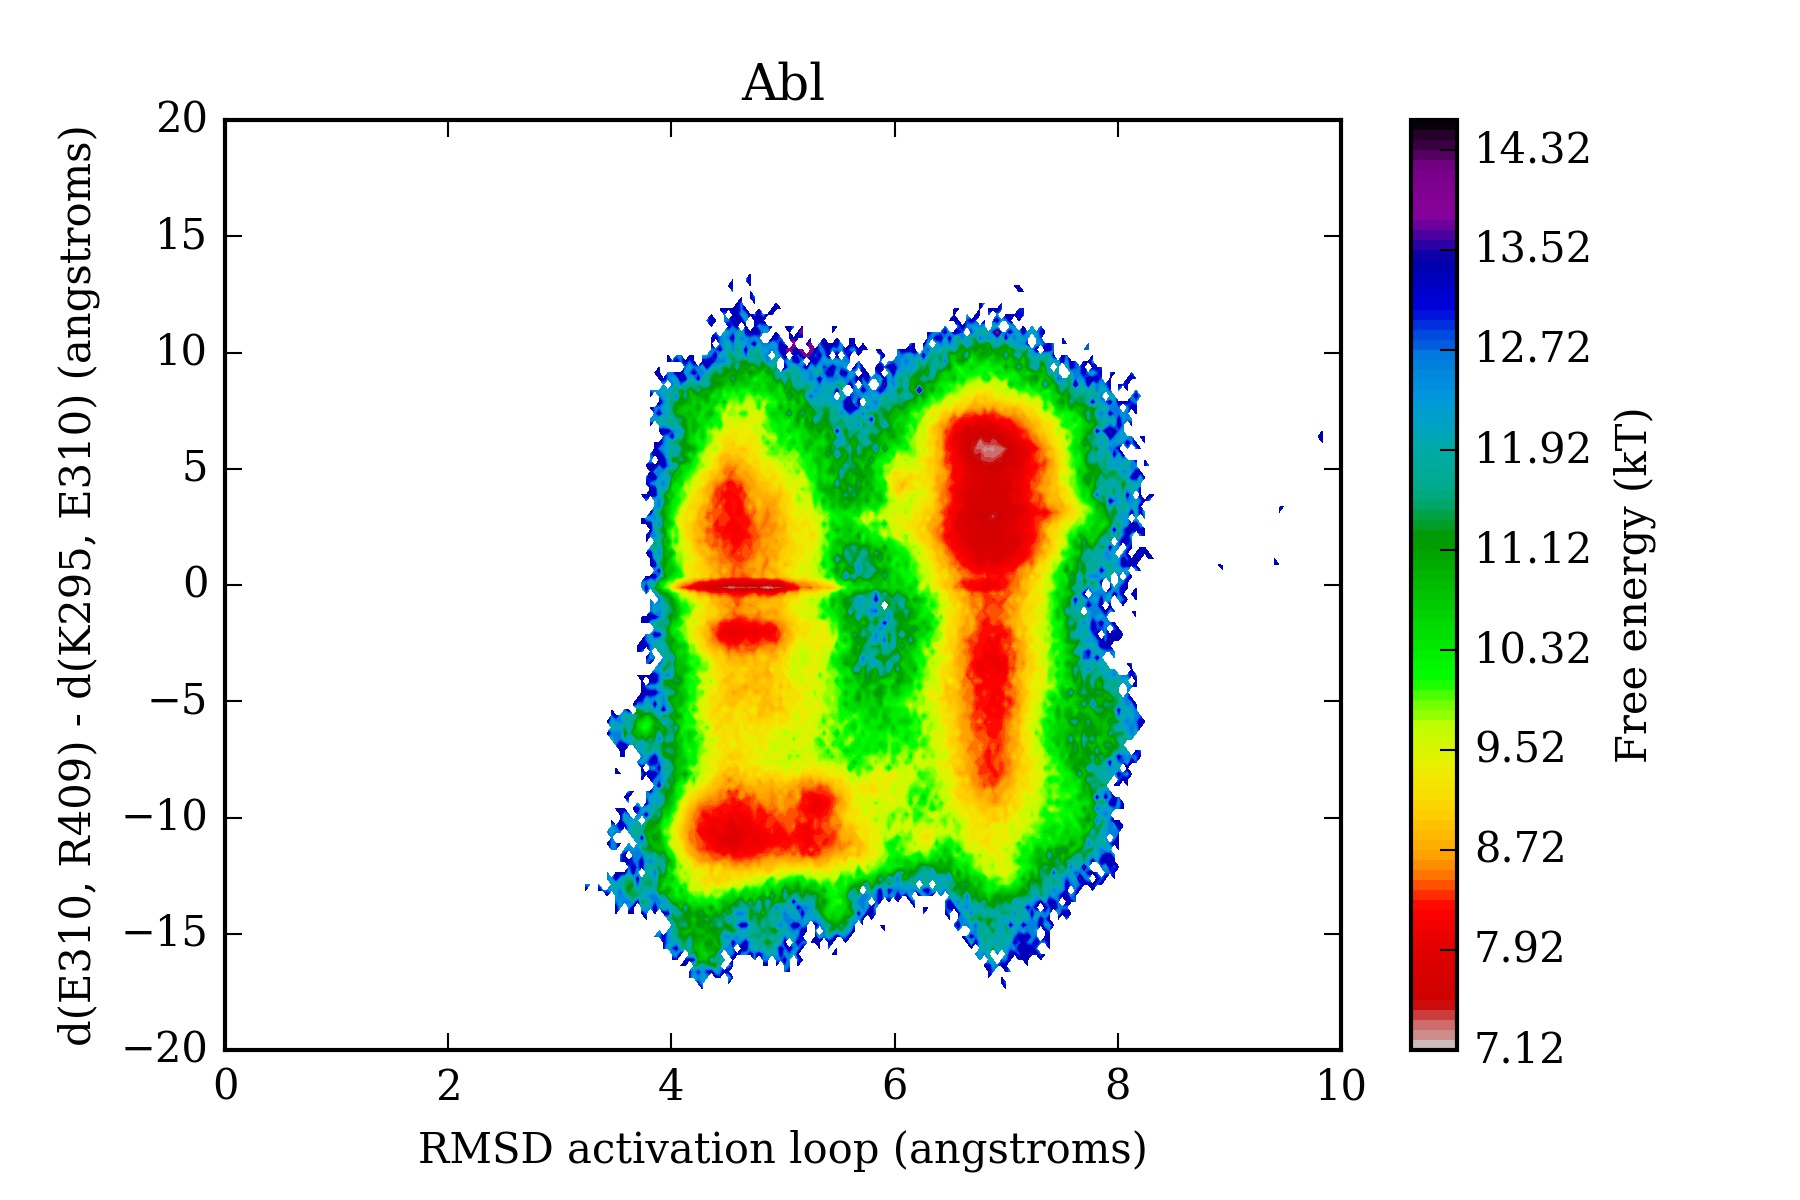

In [57]:
import pyemma


def shukla_plot(X1,X2,flat_probs,title='Abl'):

    # with weights
    ax = plt.gca()
    ax.set_xlim(0,10)
    ax.set_ylim(-20,20)

    pyemma.plots.plot_free_energy(X1,X2,flat_probs,ax,offset=0,nbins=250,cmap='spectral_r')

    plt.xlabel('RMSD activation loop (angstroms)')
    plt.ylabel('d(E310, R409) - d(K295, E310) (angstroms)')
    plt.title(title)
    plt.savefig('{0}_free_energy_landscape.jpg'.format(title),dpi=300)
    plt.close()
    
shukla_plot(X1,X2,flat_probs,'Abl')
Image('Abl_free_energy_landscape.jpg',retina=True)

In [59]:
# # without weights
# shukla_plot(X1,X2,np.ones(len(X1)),'Abl_flat')
# Image('Abl_flat_free_energy_landscape.jpg',retina=True)

MSM contains 1789 strongly connected components above weight=0.50. Component 49 selected, with population 23.611457%
Markov state model
------------------
Lag time         : 40
Reversible type  : mle
Ergodic cutoff   : 0.5
Prior counts     : 0

Number of states : 52
Number of nonzero entries in counts matrix : 1153 (42.6405325444%)
Nonzero counts matrix entries:
    Min.   : 0.0
    1st Qu.: 0.1
    Median : 0.2
    Mean   : 0.9
    3rd Qu.: 0.7
    Max.   : 61.7

Total transition counts :
    991.9 counts
Total transition counts / lag_time:
    24.7975 units
Timescales:
    [2308.10, 1141.29, 346.74, 293.34, 258.27, 200.46, 168.38, 152.31, 97.69, 92.18, 55.69, 52.05, 47.25, 40.30, 36.65, 36.12, 34.67, 34.10, 33.49, 32.46, 31.89, 30.82, 29.98, 29.23, 28.68, 27.99, 27.18, 26.23, 25.63, 24.72, 24.21, 23.79, 23.23, 22.49, 22.08, 21.65, 21.46, 21.01, 20.38, 19.89, 19.03, 18.70, 16.98, 15.40, 15.14, 14.36, 12.20, nan, nan, nan, nan]  units



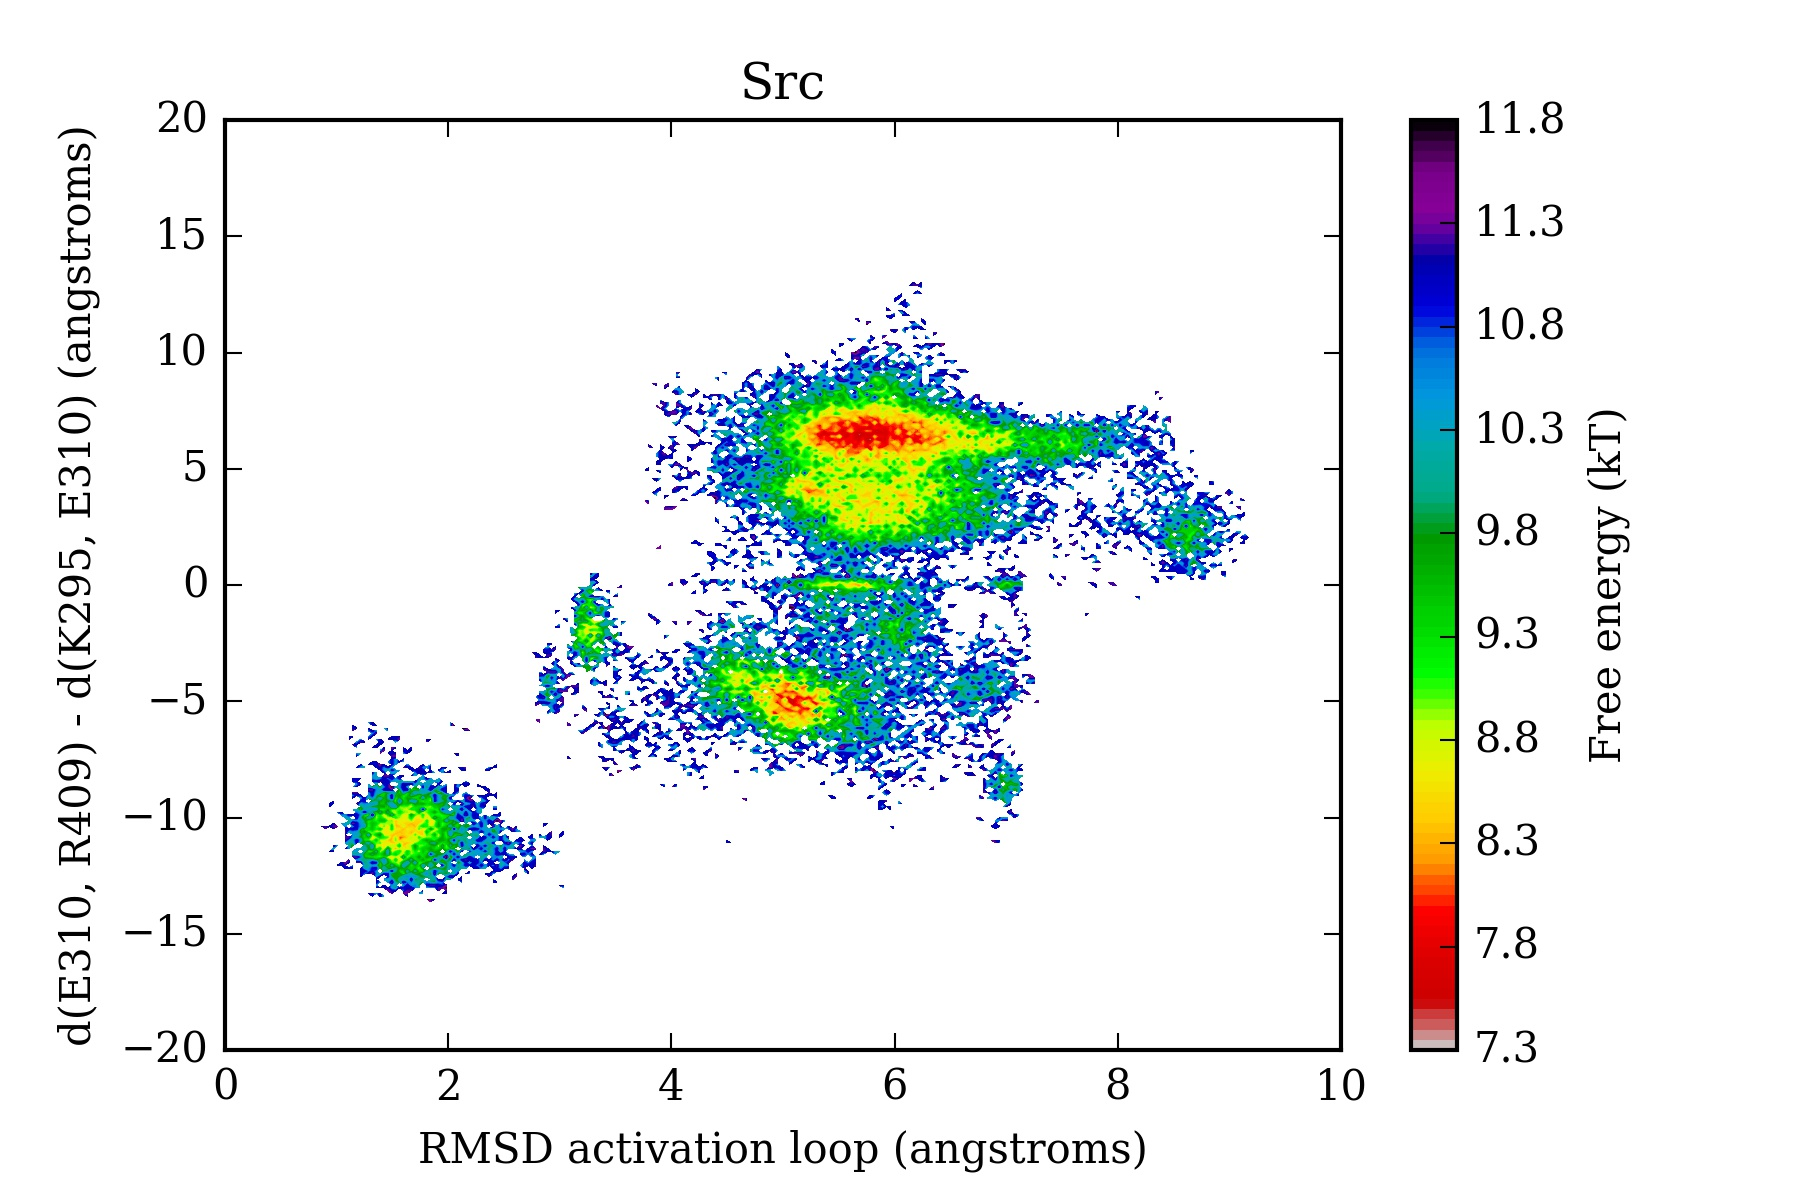

In [64]:
# now redo it for src!

raw_dtrajs_src = load_dtrajs_from_npz('dtrajs/src_11401_2000_dtrajs.npz')
dtrajs_src = trim_dtrajs(raw_dtrajs_src)

mb_msm_src = msmbuilder.msm.MarkovStateModel(lag_time=lag_frames,ergodic_cutoff=ergodic_cutoff)
mb_msm_src.fit(dtrajs_src)
print(mb_msm_src.summarize())

X1 = np.load('rmsd_SRC.npy')            # of shape (N)
X2 = np.load('difference_SRC.npy')[:,0] # since it's of shape (N,1)

flat_labels = np.hstack(raw_dtrajs_src)
flat_probs = flat_probs_from_msm(flat_labels,mb_msm_src,len(set(flat_labels)))

shukla_plot(X1,X2,flat_probs,'Src')
Image('Src_free_energy_landscape.jpg',retina=True)